In [61]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, SensitivityAtSpecificity
from tensorflow.keras.optimizers import Adam, Adagrad, RMSprop
#internal validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, balanced_accuracy_score, matthews_corrcoef, auc, average_precision_score, roc_auc_score, balanced_accuracy_score, roc_curve, accuracy_score

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import pickle

# fix random seed for reproducibility
tf.random.set_seed(1234)

target_outcome = 'outcome_combined_12months'
max_codes = 500

In [2]:
# load the dataset but only keep the top n words, zero the rest
data = pickle.load(open('../SeqModel/data_therapy.sav', 'rb'))
code2idx = pickle.load(open('../SeqModel/code2idx_therapy.sav', 'rb'))
idx2code = pickle.load(open('../SeqModel/idx2code_therapy.sav', 'rb'))

vocab_size = len(code2idx)
vocab_size

4824

In [3]:
# #Data split conventional (mixed countries)
# trainingData, testData = train_test_split(data, test_size=0.1, stratify=data[target_outcome], random_state=1234)
# trainingData, valData = train_test_split(trainingData, test_size=0.2, stratify=trainingData[target_outcome], random_state=1234)
# print(trainingData.shape)
# print(valData.shape)
# print(testData.shape)

In [4]:
#Data split, train=England, eval=Scot+Wales
trainingData = data[(data.Country == 'England') & (data.age >= 18)]
trainingData, valData = train_test_split(trainingData, test_size=0.2, stratify=trainingData[target_outcome], random_state=1234)
trainingData, evalData = train_test_split(trainingData, test_size=0.2, stratify=trainingData[target_outcome], random_state=1234)
testData = data[((data.Country == 'Wales') | (data.Country == 'Scotland')) & (data.age >= 18)]
testDataWales = data[(data.Country == 'Wales') & (data.age >= 18)]
testDataScotland = data[(data.Country == 'Scotland') & (data.age >= 18)]

In [5]:
print('Train: ', trainingData.shape[0])
print('Val: ', valData.shape[0])
print('Eval (internal validation): ', evalData.shape[0])
print('Test: ', testData.shape[0])
print('Test - Wales: ', testDataWales.shape[0])
print('Test - Scotland: ', testDataScotland.shape[0])

Train:  3257
Val:  1019
Eval (internal validation):  815
Test:  1394
Test - Wales:  914
Test - Scotland:  480


In [8]:
print(trainingData.patid.unique().shape)
print(trainingData.shape)

(3257,)
(3257, 11)


In [12]:
#make sure no data leak between sets
print(list(set(trainingData.patid.values).intersection(set(valData.patid.values))))
print(list(set(trainingData.patid.values).intersection(set(evalData.patid.values))))
print(list(set(trainingData.patid.values).intersection(set(testData.patid.values))))
print(list(set(testData.patid.values).intersection(set(testDataScotland.patid.values))))

[]
[]
[]
[43487233, 43487235, 43464708, 43378699, 43139096, 43378721, 43165731, 43487269, 43165737, 43165746, 43325496, 43311166, 43464772, 43227211, 43466834, 43378773, 43311191, 43339865, 43139165, 43284586, 43374709, 43139214, 43315349, 43165847, 43430042, 43442340, 43145381, 43327661, 43350191, 43491513, 43315386, 43135161, 43145404, 43253954, 43430083, 43190477, 43339982, 43190478, 43253966, 43303126, 43423963, 43430108, 43426012, 43251950, 43317488, 43340029, 43317502, 43190531, 43317508, 43190533, 43204870, 43491591, 43340044, 43317518, 43430159, 43190548, 43317526, 43208987, 43315486, 43317538, 43254052, 43208998, 43317543, 43209011, 43430199, 43430210, 43413830, 43489611, 43340108, 43209038, 43491667, 43340118, 43477336, 43491680, 43491683, 43272551, 43413865, 43426174, 43342206, 43413898, 43336077, 43209102, 43489679, 43342222, 43489683, 43426195, 43489687, 43188637, 43342248, 43491760, 43262384, 43145648, 43262393, 43426234, 43420103, 43336137, 43426256, 43491794, 43373014, 

In [13]:
print(trainingData[target_outcome].value_counts(normalize=True))
print(valData[target_outcome].value_counts(normalize=True))
print(evalData[target_outcome].value_counts(normalize=True))
print(testData[target_outcome].value_counts(normalize=True))

0    0.79521
1    0.20479
Name: outcome_combined_12months, dtype: float64
0    0.794897
1    0.205103
Name: outcome_combined_12months, dtype: float64
0    0.795092
1    0.204908
Name: outcome_combined_12months, dtype: float64
0    0.727403
1    0.272597
Name: outcome_combined_12months, dtype: float64


In [14]:
# X and y
X_train = np.array(trainingData.read_code_seq_padded_idx.values)
X_train = np.array([x for x in X_train])
X_val = np.array(valData.read_code_seq_padded_idx.values)
X_val = np.array([x for x in X_val])
X_eval = np.array(evalData.read_code_seq_padded_idx.values)
X_eval = np.array([x for x in X_eval])
X_test = np.array(testData.read_code_seq_padded_idx.values)
X_test = np.array([x for x in X_test])
X_testWales = np.array(testDataWales.read_code_seq_padded_idx.values)
X_testWales = np.array([x for x in X_testWales])
X_testScotland = np.array(testDataScotland.read_code_seq_padded_idx.values)
X_testScotland = np.array([x for x in X_testScotland])

y_train = trainingData[target_outcome].values
y_val = valData[target_outcome].values
y_eval = evalData[target_outcome].values
y_test = testData[target_outcome].values
y_testWales = testDataWales[target_outcome].values
y_testScotland = testDataScotland[target_outcome].values

In [15]:
print('Train: ', X_train.shape[0])
print('Val: ', X_val.shape[0])
print('Eval (internal validation): ', X_eval.shape[0])
print('Test: ', X_test.shape[0])
print('Test - Wales: ', X_testWales.shape[0])
print('Test - Scotland: ', X_testScotland.shape[0])

Train:  3257
Val:  1019
Eval (internal validation):  815
Test:  1394
Test - Wales:  914
Test - Scotland:  480


In [143]:
# create the model
embedding_vector_length = 100
earlyStopping = EarlyStopping(monitor='val_auc', patience=10, verbose=0, mode='max', restore_best_weights=True)
mcp_save = ModelCheckpoint('../SeqModel/seqModel_therapy.mdl_wts.hdf5', save_best_only=True, monitor='val_auc', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

with tf.device('/CPU:0'):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_vector_length, input_length=max_codes))
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    opt = RMSprop(learning_rate=0.0005)
    metrics = [
        AUC(num_thresholds=4000, name='auc'),
    ]
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=metrics, )
    print(model.summary())
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=64, class_weight = {0: 1, 1: 4}, callbacks = [earlyStopping, mcp_save])

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 500, 100)          482400    
                                                                 
 lstm_30 (LSTM)              (None, 500, 100)          80400     
                                                                 
 dropout_33 (Dropout)        (None, 500, 100)          0         
                                                                 
 lstm_31 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_34 (Dropout)        (None, 100)               0         
                                                                 
 dense_30 (Dense)            (None, 64)                6464      
                                                                 
 dense_31 (Dense)            (None, 1)               

/opt/conda/envs/rapids/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


51/51 [==============================] - 35s 691ms/step - loss: 0.8895 - auc: 0.7962 - val_loss: 0.4320 - val_auc: 0.8435
Epoch 3/30
51/51 [==============================] - 35s 681ms/step - loss: 0.7148 - auc: 0.8732 - val_loss: 0.4548 - val_auc: 0.8471
Epoch 4/30
51/51 [==============================] - 34s 673ms/step - loss: 0.6134 - auc: 0.9081 - val_loss: 0.4545 - val_auc: 0.8482
Epoch 5/30
51/51 [==============================] - 34s 666ms/step - loss: 0.5396 - auc: 0.9273 - val_loss: 0.3864 - val_auc: 0.8478
Epoch 6/30
51/51 [==============================] - 34s 661ms/step - loss: 0.4863 - auc: 0.9377 - val_loss: 0.4452 - val_auc: 0.8526
Epoch 7/30
51/51 [==============================] - 34s 661ms/step - loss: 0.4561 - auc: 0.9461 - val_loss: 0.4657 - val_auc: 0.8480
Epoch 8/30
51/51 [==============================] - 34s 668ms/step - loss: 0.4403 - auc: 0.9484 - val_loss: 0.4249 - val_auc: 0.8527
Epoch 9/30
51/51 [==============================] - 33s 640ms/step - loss: 0.394

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


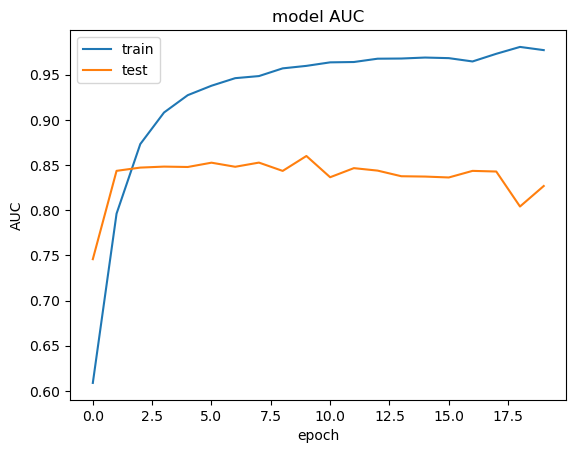

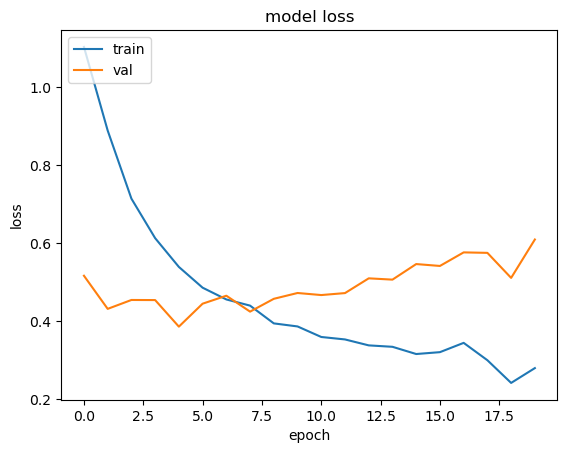

In [144]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
# plt.ylim(0.3, 1)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [145]:
with tf.device('/CPU:0'):
    model.evaluate(X_eval, y_eval)
    model.evaluate(X_test, y_test)
    model.evaluate(X_testWales, y_testWales)
    model.evaluate(X_testScotland, y_testScotland)

15/15 [==============================] - 2s 161ms/step - loss: 0.6973 - auc: 0.7071


In [154]:
#Model evaluation function
def summariseResult (testY, preds):
    tn, fp, fn, tp = confusion_matrix(testY, preds).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    ppv = 100*tp/(tp+fp)
    npv = 100*tn/(fn+tn)
    acc = accuracy_score(testY, preds)
    f1score = f1_score(testY, preds, average = 'binary')
    balanceacc = balanced_accuracy_score(testY, preds)
    fpr, tpr, thresholds = roc_curve(testY, preds, pos_label=1)
    aucscore = auc(fpr, tpr)
    # aucscore = roc_auc_score(testY, preds)
    auprc = average_precision_score(testY, preds)
    # plot_confusion_matrix(model, testX, testY, cmap='viridis')  
    return np.round(acc,4), np.round(specificity,4), np.round(sensitivity,4), np.round(aucscore,4), np.round(auprc,4), np.round(balanceacc,4), np.round(f1score,4), np.round(ppv,4), np.round(npv,4)

data_test_Xs = [X_eval, X_test, X_testWales, X_testScotland]
data_test_ys = [y_eval, y_test, y_testWales, y_testScotland]
for data_test_X, data_test_y in zip(data_test_Xs, data_test_ys):
    with tf.device('/CPU:0'):
        preds = model.predict(data_test_X)
    preds = [0 if pred <0.5 else 1 for pred in preds]
    print(summariseResult(data_test_y, np.squeeze(preds)))

26/26 [==============================] - 4s 159ms/step
(0.8405, 0.8472, 0.8144, 0.8308, 0.5093, 0.8308, 0.6766, 57.8723, 94.6552)
44/44 [==============================] - 7s 157ms/step
(0.7912, 0.8156, 0.7263, 0.7709, 0.5076, 0.7709, 0.6548, 59.6112, 88.8292)
29/29 [==============================] - 5s 154ms/step
(0.8195, 0.8187, 0.8214, 0.8201, 0.5692, 0.8201, 0.715, 63.3028, 92.3339)
15/15 [==============================] - 2s 152ms/step
(0.7375, 0.8097, 0.5391, 0.6744, 0.3964, 0.6744, 0.5227, 50.7353, 82.8488)


In [157]:
model.save('../SeqModel/model_therapy.h5')

In [156]:
# from keras.models import load_model
# a = load_model('../SeqModel/my_model.h5')